# Introduction

Some initial thoughts on "simple fish".  I.e., iterative maps that the following properties.

1. They are as simple as possible (which is, of course, in the eye of the beholder).
2. They include the 0 function.
3. They include the identity function.
4. They can be linear/affine or non-linear.
5. They have a "waist" (i.e., they can be restricted to a low dimensional manifold of a prescribed dimension).
6. They can be initialized using PCA. 

That seems like a lot to ask!  I mean, MLPs do *not* have many of those properties.   Fortuantely, I think there is a path forward.

# Derivation

## Linear

$Wx$

## Affine

$W \cdot x + b$

## Squared nonlinearity

It is tempting (and many give in to the temptation) to write

$(W \cdot x + b)^2$ 

Of course, this makes no sense! 😟 

What is really meant is that we do an entrywise squaring of the vector $(W \cdot x + b)$, which can be written as

$(W \cdot x + b) \odot (W \cdot x + b)$

where $\odot$ is the Hadamard (or entrywise) product.

## Again we are mislead by our scalar thinking

For scalar variables it is quite natural to think of squaring as the simplest nonlinearity, but in the vector case we are being a bit provincial if we do that.  E.g. why is

$$
\begin{bmatrix}
x_1 \\
x_2 \\
\end{bmatrix}
\odot
\begin{bmatrix}
x_1 \\
x_2 \\
\end{bmatrix}
=
\begin{bmatrix}
x_1^2 \\
x_2^2 \\
\end{bmatrix}
$$

any simpler than
$$
x_1
\begin{bmatrix}
x_1 \\
x_2 \\
\end{bmatrix}
=
\begin{bmatrix}
x_1 x_1 \\
x_1 x_2 \\
\end{bmatrix}
$$

In fact, the later is perhaps even simpler in that it is a (non-linear) scalar product rather than a scary Hadamard product 😎.

# The simplest non-linear map that makes Randy happy

So, all that ink spilled, what is the simplest non-linear map that makes Randy happy?  Well, it is

$$
(W_1 \cdot x + b_1) \odot (W_2 \cdot x + b_2)
$$

Let's check all of our constraints

### 1. They are as simple as possible (which is, of course, in the eye of the beholder).

By construction 😋

### 2. They include the 0 function.

$$
(0 \cdot x + 0) \odot (0 \cdot x + 0) = 0
$$

In fact, they include many zero functions, for example here is another

$$
(W_1 \cdot x + b_1) \odot (0 \cdot x + 0) = 0
$$

### 3. They include the identity function.

$$
(I \cdot x + 0) \odot (0 \cdot x + 1) = x \odot 1 = x
$$

### 4. They can be linear/affine or non-linear.

Nonlinearity by construction 😋

Every affine map is a special case of this map, e.g.,

$$
(W_1 \cdot x + b_1) \odot (0 \cdot x + 1) = (W_1 \cdot x + b_1) \odot 1 = W_1 \cdot x + b_1
$$

### 5. They have a "waist" (i.e., they can be restricted to a low dimensional manifold of a prescribed dimension).

This is the most interesting part.  Let's look at the map

$$
( (U_1 \cdot V^T) \cdot x + b_1) \odot ( (U_2 \cdot V^T) \cdot x + b_2) = \\
( U_1 \cdot (V^T \cdot x) + b_1) \odot ( U_2 \cdot (V^T \cdot x) + b_2) = \\
( U_1 \cdot y + b_1) \odot ( U_2 \cdot y + b_2) = \\
f(y)
$$

where $y = V^T \cdot x$ and $f(y)$ is desired map.  Now, if we have that $U_1, U_2, V \in \mathbb{R}^{D \times d}$, where $d$ is the dimension of the manifold we want to restrict to, then we have a function of $d$ parameters embedded in a $D$ dimensional space. I.e., a $d$-dimensional manifold in $D$ dimensional space. This is exactly the "waist" that we are looking for. 

Note, there are two interesting cases here.  

First, we can *define* $W_1 = U_1 \cdot V^T$ and $W_2 = U_2 \cdot V^T$ and then do gradient descent on the parameters matrices $U_1,U_2,V$. In this case we will do gradient descent to search for a minimizer over a space of $d$-dimensional manifolds.

Second, we can *initialize* $W_1 = U_1 \cdot V^T$ and $W_2 = U_2 \cdot V^T$ and then do gradient descent on the parameters matrices $W_1,W_2$. In this case we will start our gradient descent search on the given $d$-dimensional manifold, but the minimizer we find may be of any dimension.


### 6. They can be initialized using PCA.

Given 5. above, this is trivial.  Given a data matrix $X \in \mathbb{R}^{D \times N}$, we can compute the SVD $X = U \Sigma V^T$ and then set $W_1 = U \Sigma U^T$.  Then

$$
( (U \cdot U^T) \cdot X + 0) \odot (0 \cdot x + 1) = \\
( (U \cdot U^T) \cdot X ) \odot 1 = \\
( U \cdot U^T) \cdot X 
$$

which is precisely the PCA projection of $X$ onto the span of the columns of $U$.

# Some numerical experiments

In [ ]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Define the transformation to apply to the MNIST images
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load the MNIST dataset
mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Create a list of tensors, where each tensor is an MNIST image
image_tensors = [image for image, label in mnist_dataset]

# Stack the tensors along the second dimension to create a tensor where each column is an MNIST image
mnist_tensor = torch.stack(image_tensors, dim=1)

# Print the shape of the tensor
print(mnist_tensor.shape)

torch.Size([1, 60000, 28, 28])


In [ ]:
X = mnist_tensor.view(60000, 784).float().T

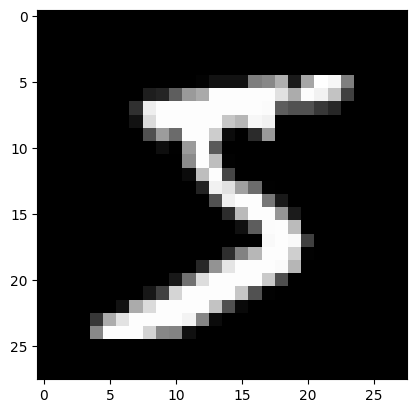

In [ ]:
plt.imshow(X[:, 0].view(28, 28), cmap='gray')

In [ ]:
U, S, V = torch.svd(X)

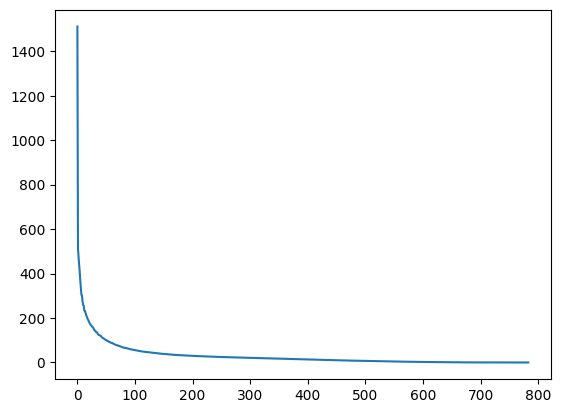

In [ ]:
plt.plot(S)

In [ ]:
strangeI = U[:, :200] @ U[:, :200].T

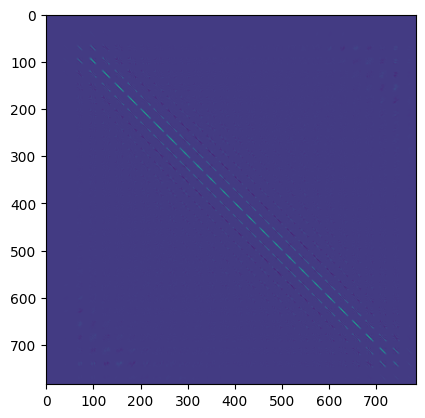

In [ ]:
plt.imshow(strangeI)

In [ ]:
XHat = strangeI @ X

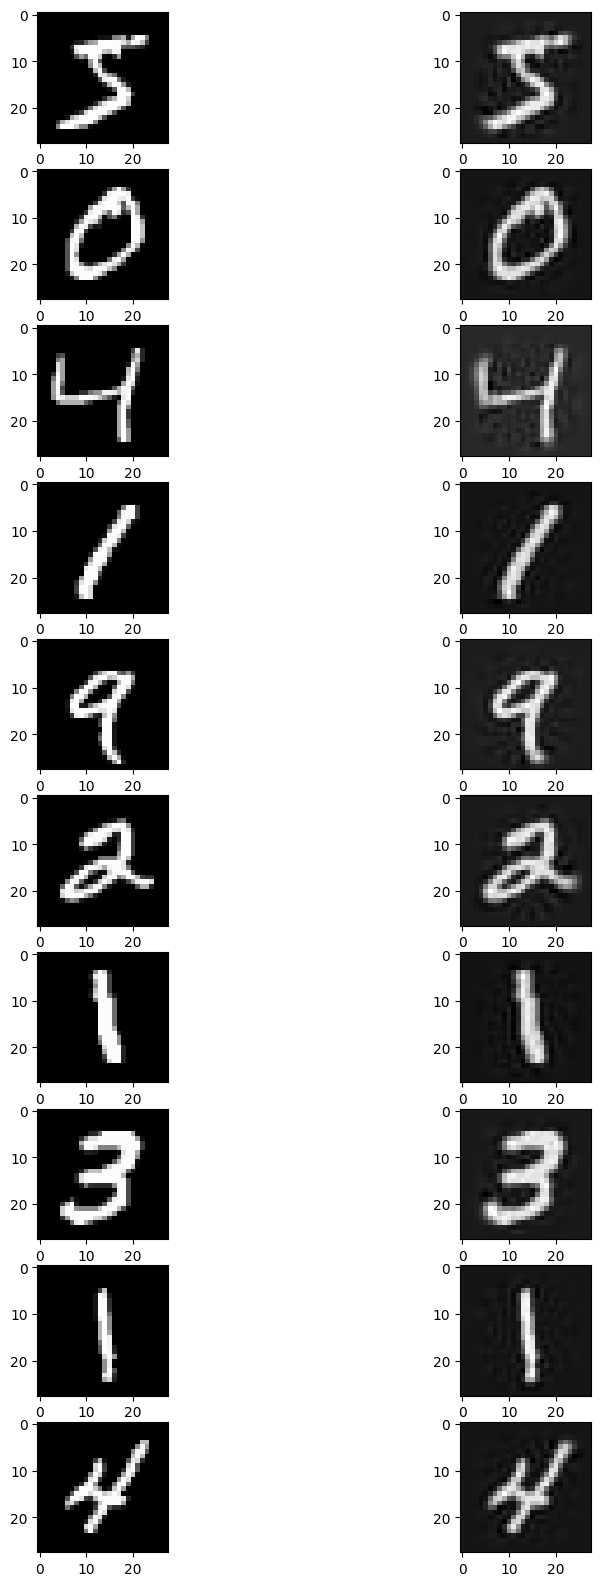

In [ ]:
_, ax = plt.subplots(10, 2, figsize=(10, 20))
for i in range(10):
    ax[i, 0].imshow(X[:, i].view(28, 28), cmap='gray')
    ax[i, 1].imshow(XHat[:, i].view(28, 28), cmap='gray')

# Another one that is important, I think

Looking at our constraints, the is a but of ambiguity.  In particular, we have

1. They are as simple as possible (which is, of course, in the eye of the beholder).
2. They include the 0 function.
3. They include the identity function.
4. ***They can be linear/affine or non-linear.***
5. They have a "waist" (i.e., they can be restricted to a low dimensional manifold of a prescribed dimension).
6. They can be initialized using PCA. 

And there are several ways to think about 4!  Abve we use a *multiplicative* non-linearity, but there are other important non-linearities.  For example, a *discontinuous* non-linearity! 😎

The non-linearity above is far from discontinuous.  In fact, it is polynomial, which is about as smooth as you can get.  But, what if we use a discontinuous non-linearity?  

For example, how about

$$
f(x) = 
\begin{cases}
    W_1 \cdot x + b_1 & \text{if } x < 0 \\
    W_2 \cdot x + b_2 & \text{else}
\end{cases}
$$

again, we are being provincial in our thinking since what does it mean to be less than zero for a vector?  so, we can be a little more precise and write

$$
f(x) = 
\begin{cases}
    W_1 \cdot x + b_1 & \text{if } x_j < 0 \\
    W_2 \cdot x + b_2 & \text{else}
\end{cases}
$$


### 1. They are as simple as possible (which is, of course, in the eye of the beholder).

By construction 😋

### 2. They include the 0 function.


$$
f(x) = 
\begin{cases}
    0 \cdot x + 0 & \text{if } x_j < 0 \\
    0 \cdot x + 0 & \text{else}
\end{cases}
$$

### 3. They include the identity function.
$$
f(x) = 
\begin{cases}
    I \cdot x + 0 & \text{if } x_j < 0 \\
    I \cdot x + 0 & \text{else}
\end{cases}
$$

### 4. They can be linear/affine or non-linear.

Nonlinearity by construction 😋

Again, every affine map is a special case of this map, e.g.,

$$
f(x) = 
\begin{cases}
    W \cdot x + b & \text{if } x_j < 0 \\
    W \cdot x + b & \text{else}
\end{cases}
$$

### 5. They have a "waist" (i.e., they can be restricted to a low dimensional manifold of a prescribed dimension).

As before, this can be

$$
f(x) = 
\begin{cases}
    (U_1 \cdot V^T) \cdot x + b_1 & \text{if } x_j < 0 \\
    (U_2 \cdot V^T) \cdot x + b_2 & \text{else}
\end{cases}
$$

where $y = V^T \cdot x$ and $f(y)$ is desired map.  Now, if we have that $U_1, U_2, V \in \mathbb{R}^{D \times d}$, where $d$ is the dimension of the manifold we want to restrict to, then we have a function of $d$ parameters embedded in a $D$ dimensional space. I.e., a $d$-dimensional manifold in $D$ dimensional space. This is exactly the "waist" that we are looking for. 

Note, there are two interesting cases here.  

First, we can *define* $W_1 = U_1 \cdot V^T$ and $W_2 = U_2 \cdot V^T$ and then do gradient descent on the parameters matrices $U_1,U_2,V$. In this case we will do gradient descent to search for a minimizer over a space of $d$-dimensional manifolds.

Second, we can *initialize* $W_1 = U_1 \cdot V^T$ and $W_2 = U_2 \cdot V^T$ and then do gradient descent on the parameters matrices $W_1,W_2$. In this case we will start our gradient descent search on the given $d$-dimensional manifold, but the minimizer we find may be of any dimension.


### 6. They can be initialized using PCA.

Given 5. above, this is trivial.  Given a data matrix $X \in \mathbb{R}^{D \times N}$, we can compute the SVD $X = U \Sigma V^T$ and then set $W_1 = U \Sigma U^T$.  Then

$$
f(x) = 
\begin{cases}
    (U \cdot U^T) \cdot x + 0 & \text{if } x_j < 0 \\
    (U \cdot U^T) \cdot x + 0 & \text{else}
\end{cases}
$$

which is precisely the PCA projection of $X$ onto the span of the columns of $U$.

### 7. This is actually a version of ReLU 😂

$$
f(x) = 
\begin{cases}
    0 \cdot x + 0 & \text{if } x_j < 0 \\
    W_2 \cdot x + b_2 & \text{else}
\end{cases}
$$
